In [24]:
#importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

path = "https://raw.githubusercontent.com/shreyrastogi0508/DemandForecasting_MinorProject/master/MedicineData.csv"
df = pd.read_csv(path)
df.head()

,date,R03
0,1/1/1992,1509
1,2/1/1992,1541
2,3/1/1992,1597
3,4/1/1992,1675
4,5/1/1992,1822


## Visualizing the Time-Series and Checking for Stationarity

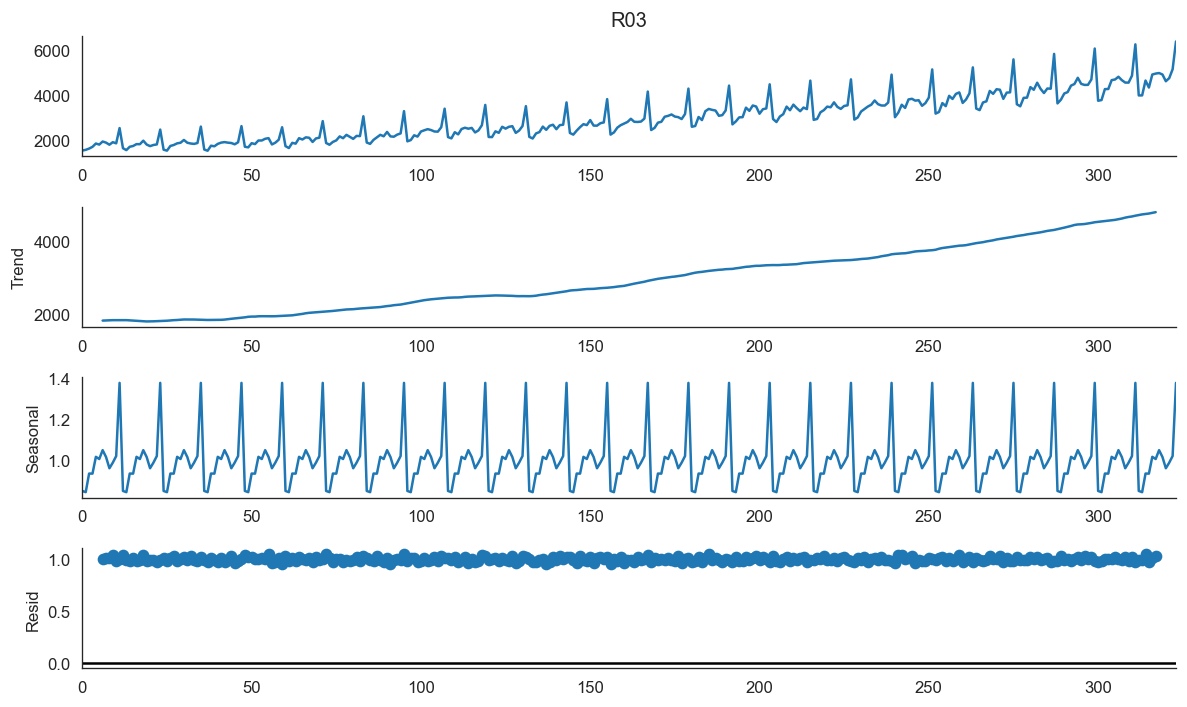

In [25]:
# decomposing the time series
plt.rcParams["figure.figsize"] = (10,6)
result = seasonal_decompose(df['R03'], model='multiplicative', period = 12)
result.plot()
plt.show()

### The data does not appear to be stationary as the time series is steadily increasing and shows annual seasonality.

## Testing the Stationarity using ADFuller Test

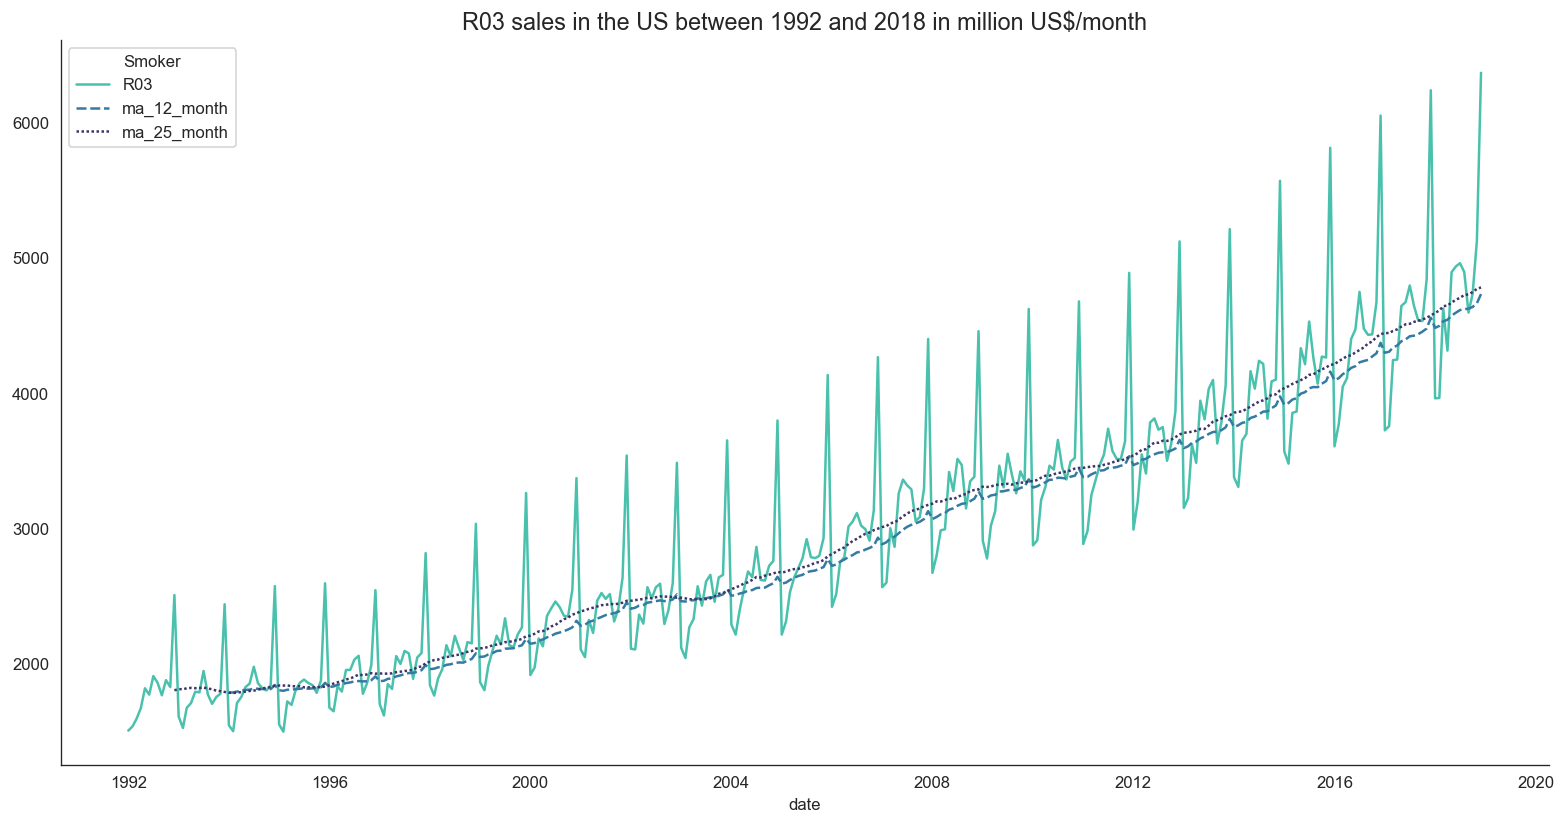

(0.019143247561159864, False)


In [26]:
def check_stationarity(df_sales, title_string, labels):
    # Visualize the data
    fig, ax = plt.subplots(figsize=(16, 8))
    plt.title(title_string, fontsize=14)
    if df_sales.index.size > 12:
        df_sales['ma_12_month'] = df_sales['R03'].rolling(window=12).mean()
        df_sales['ma_25_month'] = df_sales['R03'].rolling(window=25).mean()
        sns.lineplot(data=df_sales[['R03', 'ma_25_month', 'ma_12_month']], palette=sns.color_palette("mako_r", 3))
        plt.legend(title='Smoker', loc='upper left', labels=labels)
    else:
        sns.lineplot(data=df_sales[['R03']])
    
    plt.show()
    
    sales = df_sales['R03'].dropna()
    # Perform an Ad Fuller Test
    # the default alpha = .05 stands for a 95% confidence interval
    adf_test = pm.arima.ADFTest(alpha = 0.05) 
    print(adf_test.should_diff(sales))
    
df_sales = pd.DataFrame(df['R03'], columns=['R03'])
df_sales.index = pd.to_datetime(df['date']) 
title = "R03 sales in the US between 1992 and 2018 in million US$/month"
labels = ['R03', 'ma_12_month', 'ma_25_month']
check_stationarity(df_sales, title, labels)

# Differencing and Autocorrelation

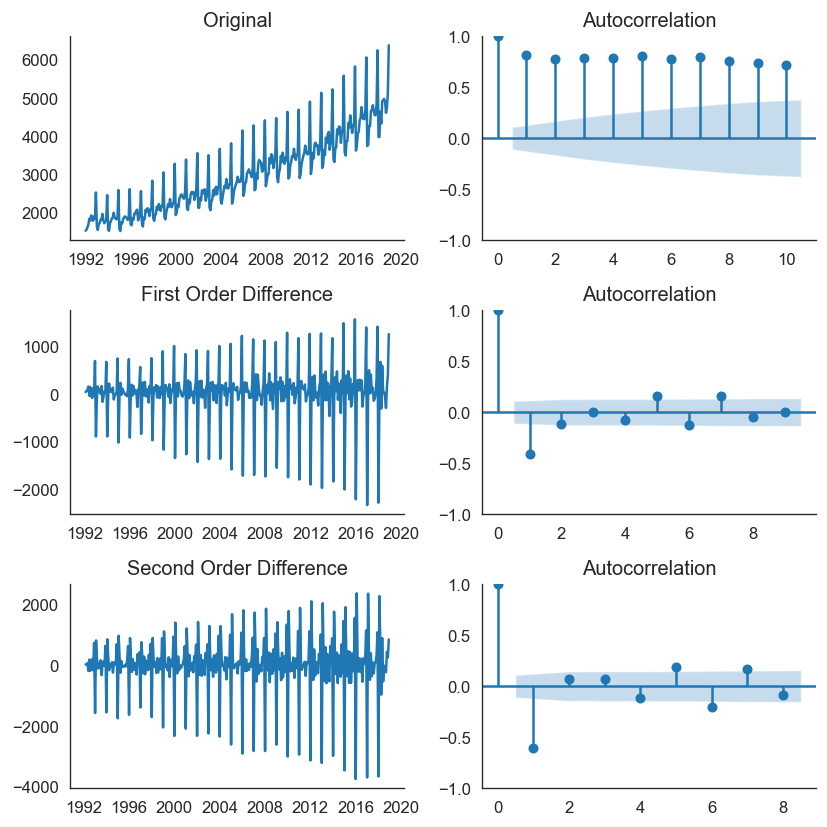

In [27]:
# 3.1 Non-seasonal part
def auto_correlation(df, prefix, lags):
    plt.rcParams.update({'figure.figsize':(7,7), 'figure.dpi':120})
    
    # Define the plot grid
    fig, axes = plt.subplots(3,2, sharex=False)

    # First Difference
    axes[0, 0].plot(df)
    axes[0, 0].set_title('Original' + prefix)
    plot_acf(df, lags=lags, ax=axes[0, 1])

    # First Difference
    df_first_diff = df.diff().dropna()
    axes[1, 0].plot(df_first_diff)
    axes[1, 0].set_title('First Order Difference' + prefix)
    plot_acf(df_first_diff, lags=lags - 1, ax=axes[1, 1])

    # Second Difference
    df_second_diff = df.diff().diff().dropna()
    axes[2, 0].plot(df_second_diff)
    axes[2, 0].set_title('Second Order Difference' + prefix)
    plot_acf(df_second_diff, lags=lags - 2, ax=axes[2, 1])
    plt.tight_layout()
    plt.show()
    
auto_correlation(df_sales['R03'], '', 10)

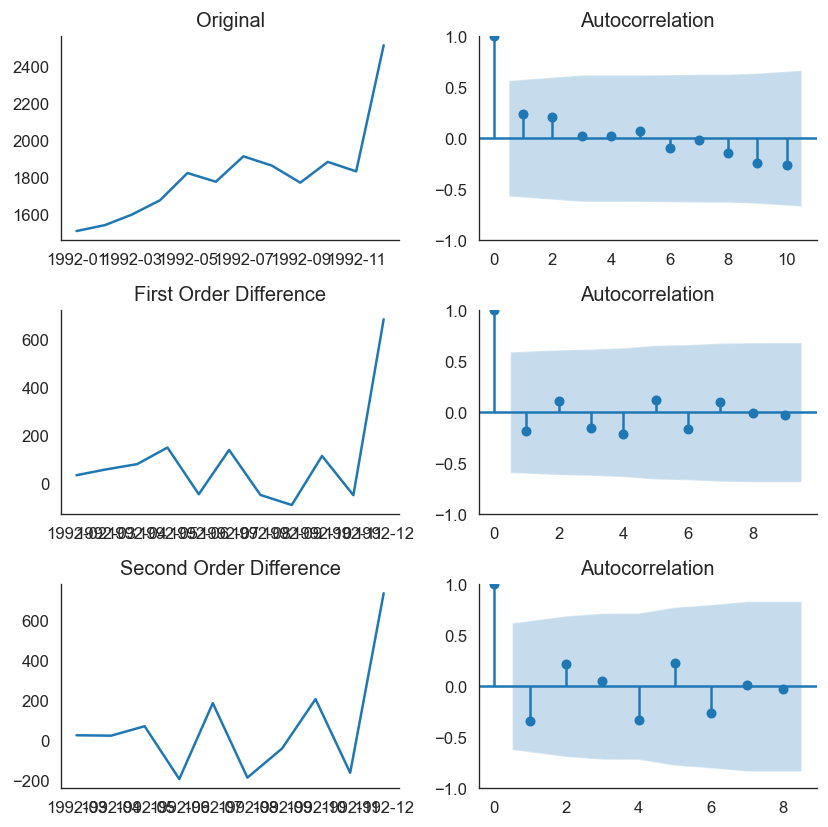

In [28]:
# 3.2 Seasonal part

# Reduce the timeframe to a single seasonal period
df_sales_s = df_sales['R03'][0:12]

# Autocorrelation for the seasonal part
auto_correlation(df_sales_s, '', 10)

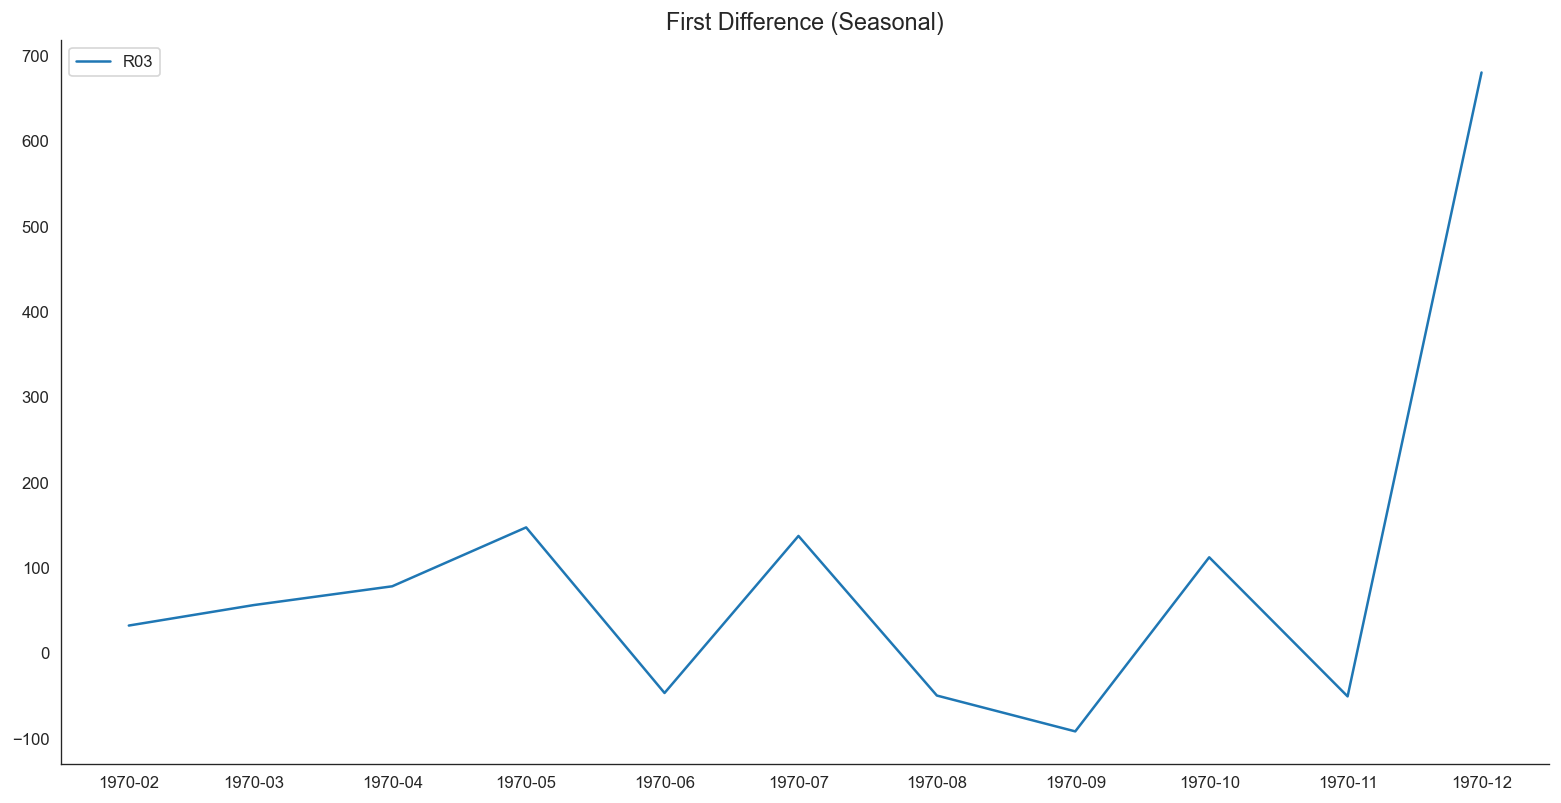

(0.99, True)


In [29]:
#checking the difference
df_diff = pd.DataFrame(df_sales_s.diff())
df_diff.index = pd.date_range(df_sales_s.diff().iloc[1], periods=12, freq='MS') 
check_stationarity(df_diff, "First Difference (Seasonal)", ['difference'])

# Finding an Optimal Model with Auto-ARIMA

In [30]:
# split into training and testing
pred_periods = 30
split_number = df_sales['R03'].count() - pred_periods # corresponds to a prediction horizion  of 2.5 years
df_train = pd.DataFrame(df_sales['R03'][:split_number]).rename(columns={'R03':'y_train'})
df_test = pd.DataFrame(df_sales['R03'][split_number:]).rename(columns={'R03':'y_test'})

# setting up auto_arima
model_fit = pm.auto_arima(df_train, test='adf', 
                         max_p=3, max_d=3, max_q=3, 
                         seasonal=True, m=12,
                         max_P=3, max_D=2, max_Q=3,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

# summarize the model characteristics
print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.54 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3383.210, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3351.655, Time=0.40 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=3364.350, Time=0.81 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3604.145, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=3349.908, Time=0.13 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=3351.532, Time=0.28 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=3353.520, Time=0.94 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=3312.656, Time=0.13 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=3314.483, Time=0.50 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=3314.378, Time=0.36 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=3305.552, Time=1.59 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=3291.425, Time=7.57 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=3306.914, Time=5.31 sec
 ARIMA(2,0,0)(3,1,1)[12]

# Testing

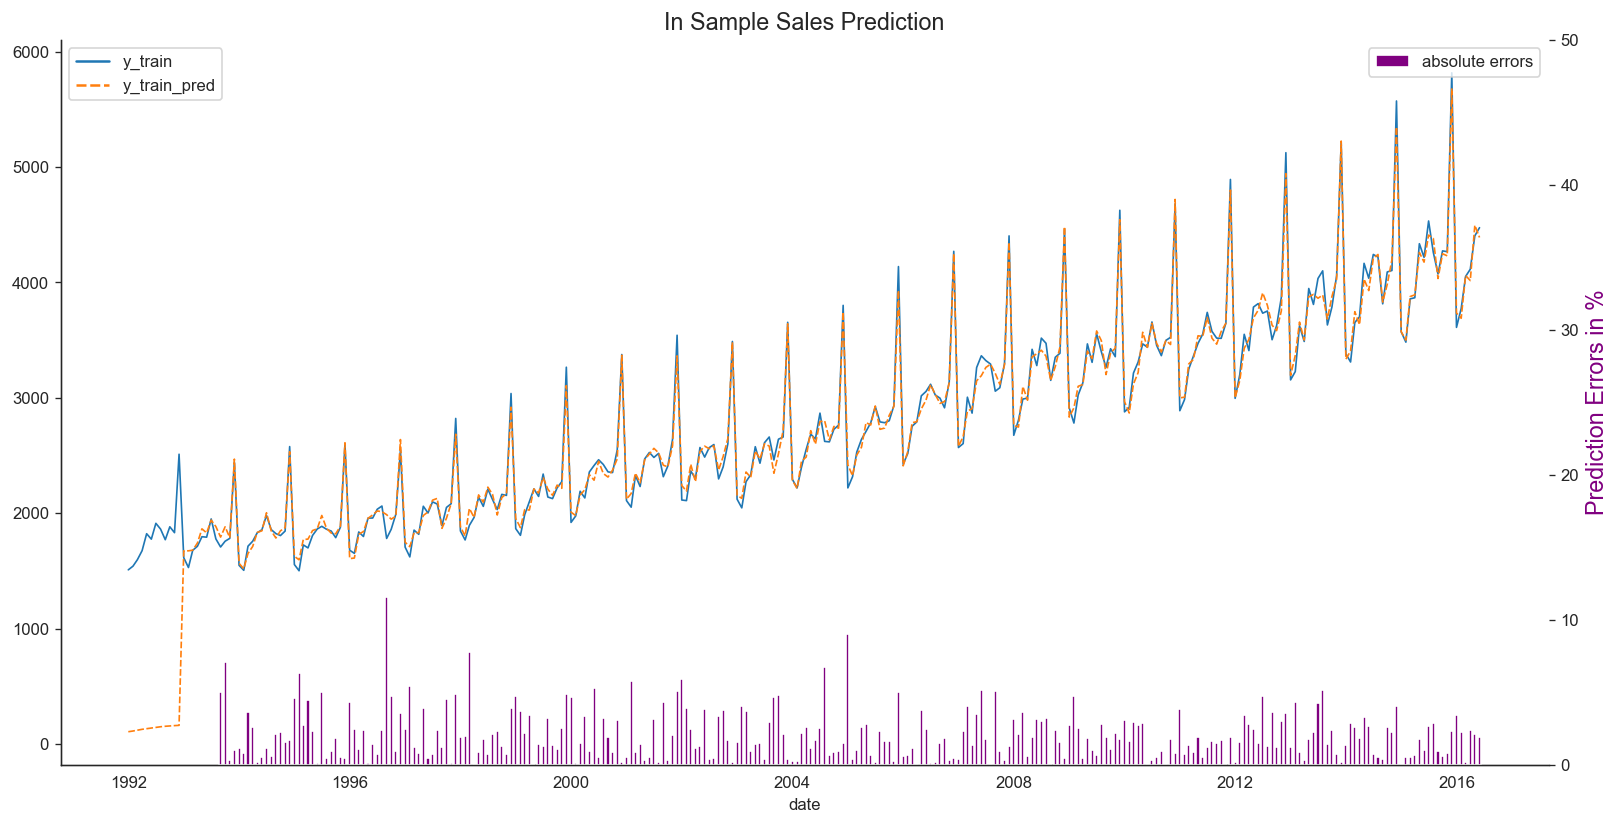

In [31]:
# Generate in-sample Predictions
# This means that the model is trained until a point in the time-series and then tries to predict the next value.
pred = model_fit.predict_in_sample(dynamic=False) # works only with auto-arima
df_train['y_train_pred'] = pred

# Calculate the percentage difference
df_train['diff_percent'] = abs((df_train['y_train'] - pred) / df_train['y_train'])* 100

# Print the predicted time-series
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("In Sample Sales Prediction", fontsize=14)
sns.lineplot(data=df_train[['y_train', 'y_train_pred']], linewidth=1.0)

# Print percentage prediction errors on a separate axis (ax2)
ax2 = ax1.twinx() 
ax2.set_ylabel('Prediction Errors in %', color='purple', fontsize=14)  
ax2.set_ylim([0, 50])
ax2.bar(height=df_train['diff_percent'][20:], x=df_train.index[20:], width=20, color='purple', label='absolute errors')
plt.legend()
plt.show()

# Visualising a Sales Forecast

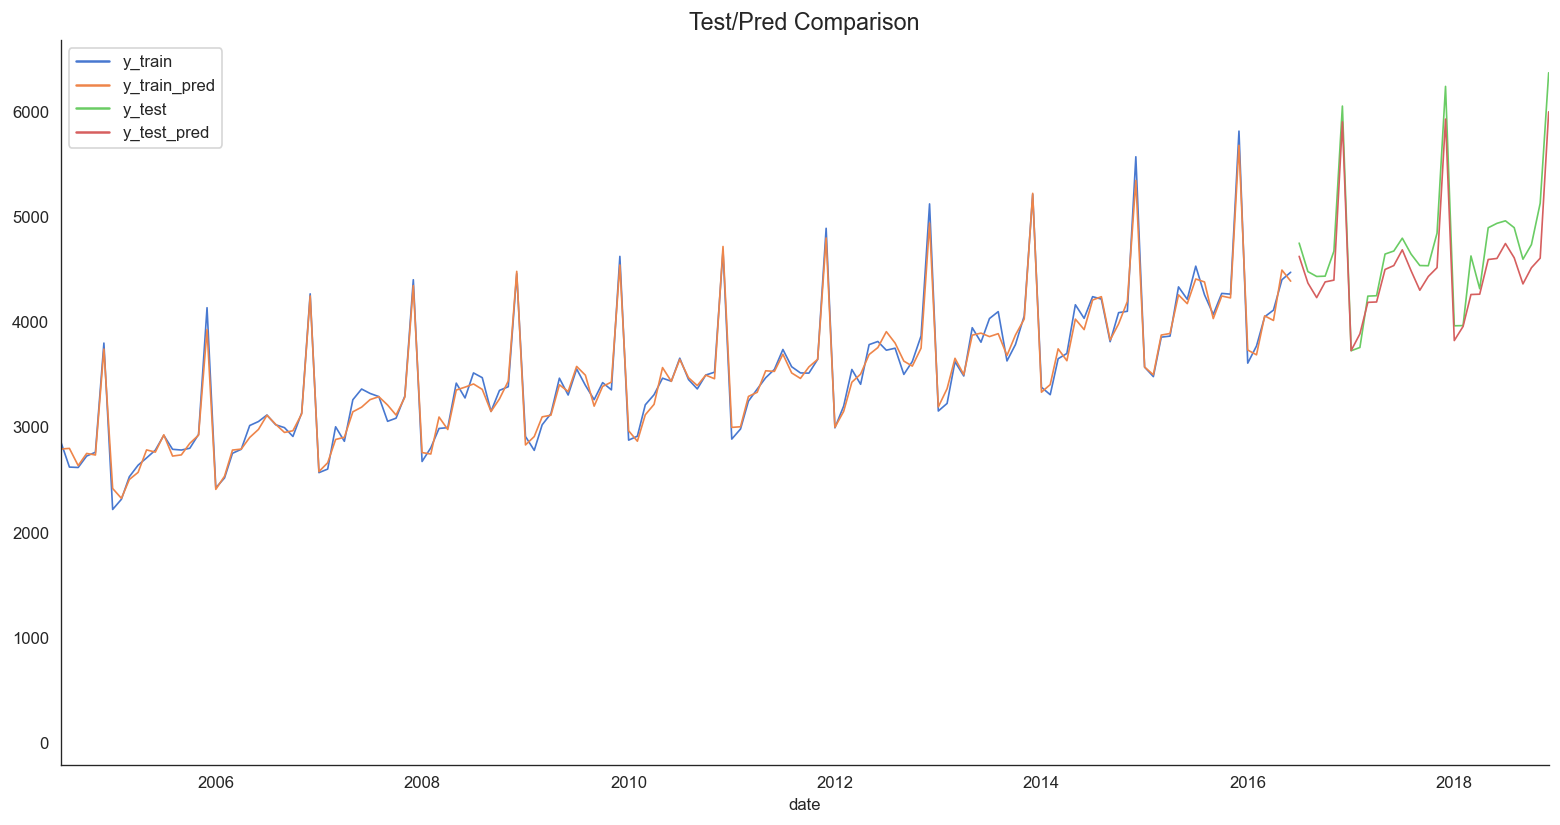

In [32]:
# Generate prediction for n periods, 
# Predictions start from the last date of the training data
test_pred = model_fit.predict(n_periods=pred_periods, dynamic=False)
df_test['y_test_pred'] = test_pred
df_union = pd.concat([df_train, df_test])
df_union.rename(columns={'R03':'y_test'}, inplace=True)

# Print the predicted time-series
fig, ax = plt.subplots(figsize=(16, 8))
plt.title("Test/Pred Comparison", fontsize=14)
sns.despine();
sns.lineplot(data=df_union[['y_train', 'y_train_pred', 'y_test', 'y_test_pred']], linewidth=1.0, dashes=False, palette='muted')
ax.set_xlim([df_union.index[150],df_union.index.max()])
plt.legend()
plt.show()

# Measuring Performance

In [33]:
# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(df_test['y_test'], df_test['y_test_pred'])/ df_test['y_test']))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')


Mean Absolute Percentage Error (MAPE): 3.94 %


#### A MAPE of 3.94% implies that the our model is approx 96.06% accurate